<a href="https://colab.research.google.com/github/samanthajmichael/ml_project/blob/main/notebooks/Match_Cut_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code imports necessary libraries and sets up the environment for training a PyTorch model on a GPU if available

In [8]:
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time
import numpy as np

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
# check GPU properties
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(torch.cuda.device))

Tesla T4
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=8a44e8a3-e7ef-5625-11a7-fe50eec13dd3, L2_cache_size=4MB)


Now we finally download the data sets, shuffle them and transform each of them. We download the data sets and load them to DataLoader, which combines the data-set and a sampler and provides single- or multi-process iterators over the data-set.

Torchvision datasets module has many built-in datsets https://pytorch.org/vision/stable/datasets.html

In [9]:
max_degree = 35
# Define transform to normalize data
train_transform = transforms.Compose([transforms.RandomRotation(max_degree),
                                transforms.ToTensor(), #GaussianBlur(kernel_size=5),
                                transforms.Normalize((0.1307,),(0.3081,)) ## this is the mean NN is very sensitive to scale so we always normalize -- we must pay attention to the normalization to how the author normalized their data
                                ])

test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,)) ## NN is very sensitive to scale so we always normalize
                                ])


In [10]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os
from PIL import Image
import pandas as pd
import random

class ImageLabelDataset(Dataset):
    def __init__(self, image_files, label_df, folder_path, max_size=100, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        # Filter image_files to only include those that exist in label_df
        valid_files = [f for f in image_files if f in label_df['filename'].values]

        # Randomly select max_size number of images if we have more than max_size
        if len(valid_files) > max_size:
            self.image_files = random.sample(valid_files, max_size)
        else:
            self.image_files = valid_files

        self.label_df = label_df

        print(f"Total valid images in dataset: {len(self.image_files)}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.folder_path, image_file)

        try:
            image = Image.open(image_path)
            # Get all relevant labels from the dataframe
            row = self.label_df[self.label_df['filename'] == image_file].iloc[0]

            # Create a dictionary of labels
            labels = {
                'has_faces': torch.tensor(row['has_faces'] == 'TRUE', dtype=torch.float),
                'num_faces': torch.tensor(row['num_faces'], dtype=torch.long),
                'face_confidence': torch.tensor(row['face_confidence'], dtype=torch.float),
                'is_scene_cut': torch.tensor(row['is_scene_cut'] == 'TRUE', dtype=torch.float),
                'scene_confidence': torch.tensor(row['scene_confidence'], dtype=torch.float),
                'frame_difference': torch.tensor(row['frame_difference'], dtype=torch.float)
            }

            if self.transform:
                image = self.transform(image)

            return image, labels

        except Exception as e:
            print(f"Error processing image {image_file}: {str(e)}")
            return None


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths
folder_path = '/content/drive/MyDrive/ML Project/15_min_consecutive_frames'
csv_path = '/content/drive/MyDrive/ML Project/labeled_data/scene_analysis_final.csv'

# Set random seed for reproducibility
random.seed(42)

# Load the label dataframe
label_df = pd.read_csv(csv_path)

# Get image files from the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Create dataset instance with max_size=100
dataset = ImageLabelDataset(
    image_files=image_files,
    label_df=label_df,
    folder_path=folder_path,
    max_size=100,
    transform=ToTensor()
)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set = torch.utils.data.Subset(dataset, range(train_size))
test_set = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

# Create data loaders
trainloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=min(32, len(train_set)),  # Reduced batch size for smaller dataset
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=min(32, len(test_set)),
    shuffle=False
)

Mounted at /content/drive
Total valid images in dataset: 100


In [11]:
# Save the dataset with complete information
dataset_info = {
    'dataset': dataset,
    'image_files': dataset.image_files,
    'label_df': dataset.label_df,
    'folder_path': dataset.folder_path,
    'transform': dataset.transform
}

# Save path
save_path = '/content/drive/MyDrive/ML Project/dataset/image_label_dataset.pt'

# Save the dataset
torch.save(dataset_info, save_path)

# To verify the save worked, try loading it:
loaded_data = torch.load(save_path)
print("\nVerifying saved data:")
print(f"Number of images: {len(loaded_data['image_files'])}")
print(f"Label DataFrame shape: {loaded_data['label_df'].shape}")
print(f"Folder path: {loaded_data['folder_path']}")


Verifying saved data:
Number of images: 100
Label DataFrame shape: (9497, 9)
Folder path: /content/drive/MyDrive/ML Project/15_min_consecutive_frames


<ipython-input-11-ba9ad2eff0ff>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(save_path)


In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def inspect_data_pipeline():
    """
    Inspect and visualize the data pipeline for scene cut detection
    """
    # Get a batch of training data
    images, labels = next(iter(trainloader))

    print("Data Pipeline Information:")
    print(f"Training set size: {len(train_set)} images")
    print(f"Test set size: {len(test_set)} images")
    print(f"\nBatch shape: {images.shape}")

    # Print shapes of all labels
    print("\nLabel shapes:")
    for key, value in labels.items():
        print(f"{key}: {value.shape}")

    # Show example batch
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    for idx in range(8):
        # Convert tensor to numpy and transpose dimensions for matplotlib
        img = images[idx].permute(1, 2, 0).numpy()  # Change from (3, H, W) to (H, W, 3)

        # Convert to grayscale by taking mean across channels if desired
        # img = img.mean(axis=2)  # Uncomment this line if you want grayscale

        # Clip values to valid range
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)  # Remove cmap='gray' for RGB images
        axes[idx].axis('off')

        # Create title with relevant information
        title = f'Scene Cut: {labels["is_scene_cut"][idx].item():.0f}\n'
        title += f'Conf: {labels["scene_confidence"][idx].item():.2f}'
        axes[idx].set_title(title)

    plt.tight_layout()
    plt.show()

    # Print distribution of scene cuts and other relevant statistics
    print("\nScene Cut Distribution in Training Set:")

    # Calculate scene cut statistics for the entire training set
    scene_cut_stats = {
        'total': len(train_set),
        'scene_cuts': 0,
        'non_scene_cuts': 0,
        'avg_confidence': 0.0,
        'avg_frame_diff': 0.0
    }

    for i in range(len(train_set)):
        _, batch_labels = train_set[i]
        is_scene_cut = batch_labels['is_scene_cut'].item()

        if is_scene_cut:
            scene_cut_stats['scene_cuts'] += 1
        else:
            scene_cut_stats['non_scene_cuts'] += 1

        scene_cut_stats['avg_confidence'] += batch_labels['scene_confidence'].item()
        scene_cut_stats['avg_frame_diff'] += batch_labels['frame_difference'].item()

    # Calculate averages
    scene_cut_stats['avg_confidence'] /= scene_cut_stats['total']
    scene_cut_stats['avg_frame_diff'] /= scene_cut_stats['total']

    print(f"\nTotal images: {scene_cut_stats['total']}")
    print(f"Scene cuts: {scene_cut_stats['scene_cuts']} ({scene_cut_stats['scene_cuts']/scene_cut_stats['total']*100:.1f}%)")
    print(f"Non-scene cuts: {scene_cut_stats['non_scene_cuts']} ({scene_cut_stats['non_scene_cuts']/scene_cut_stats['total']*100:.1f}%)")
    print(f"Average scene confidence: {scene_cut_stats['avg_confidence']:.3f}")
    print(f"Average frame difference: {scene_cut_stats['avg_frame_diff']:.3f}")


Data Pipeline Information:
Training set size: 80 images
Test set size: 20 images

Batch shape: torch.Size([32, 3, 696, 1280])

Label shapes:
has_faces: torch.Size([32])
num_faces: torch.Size([32])
face_confidence: torch.Size([32])
is_scene_cut: torch.Size([32])
scene_confidence: torch.Size([32])
frame_difference: torch.Size([32])


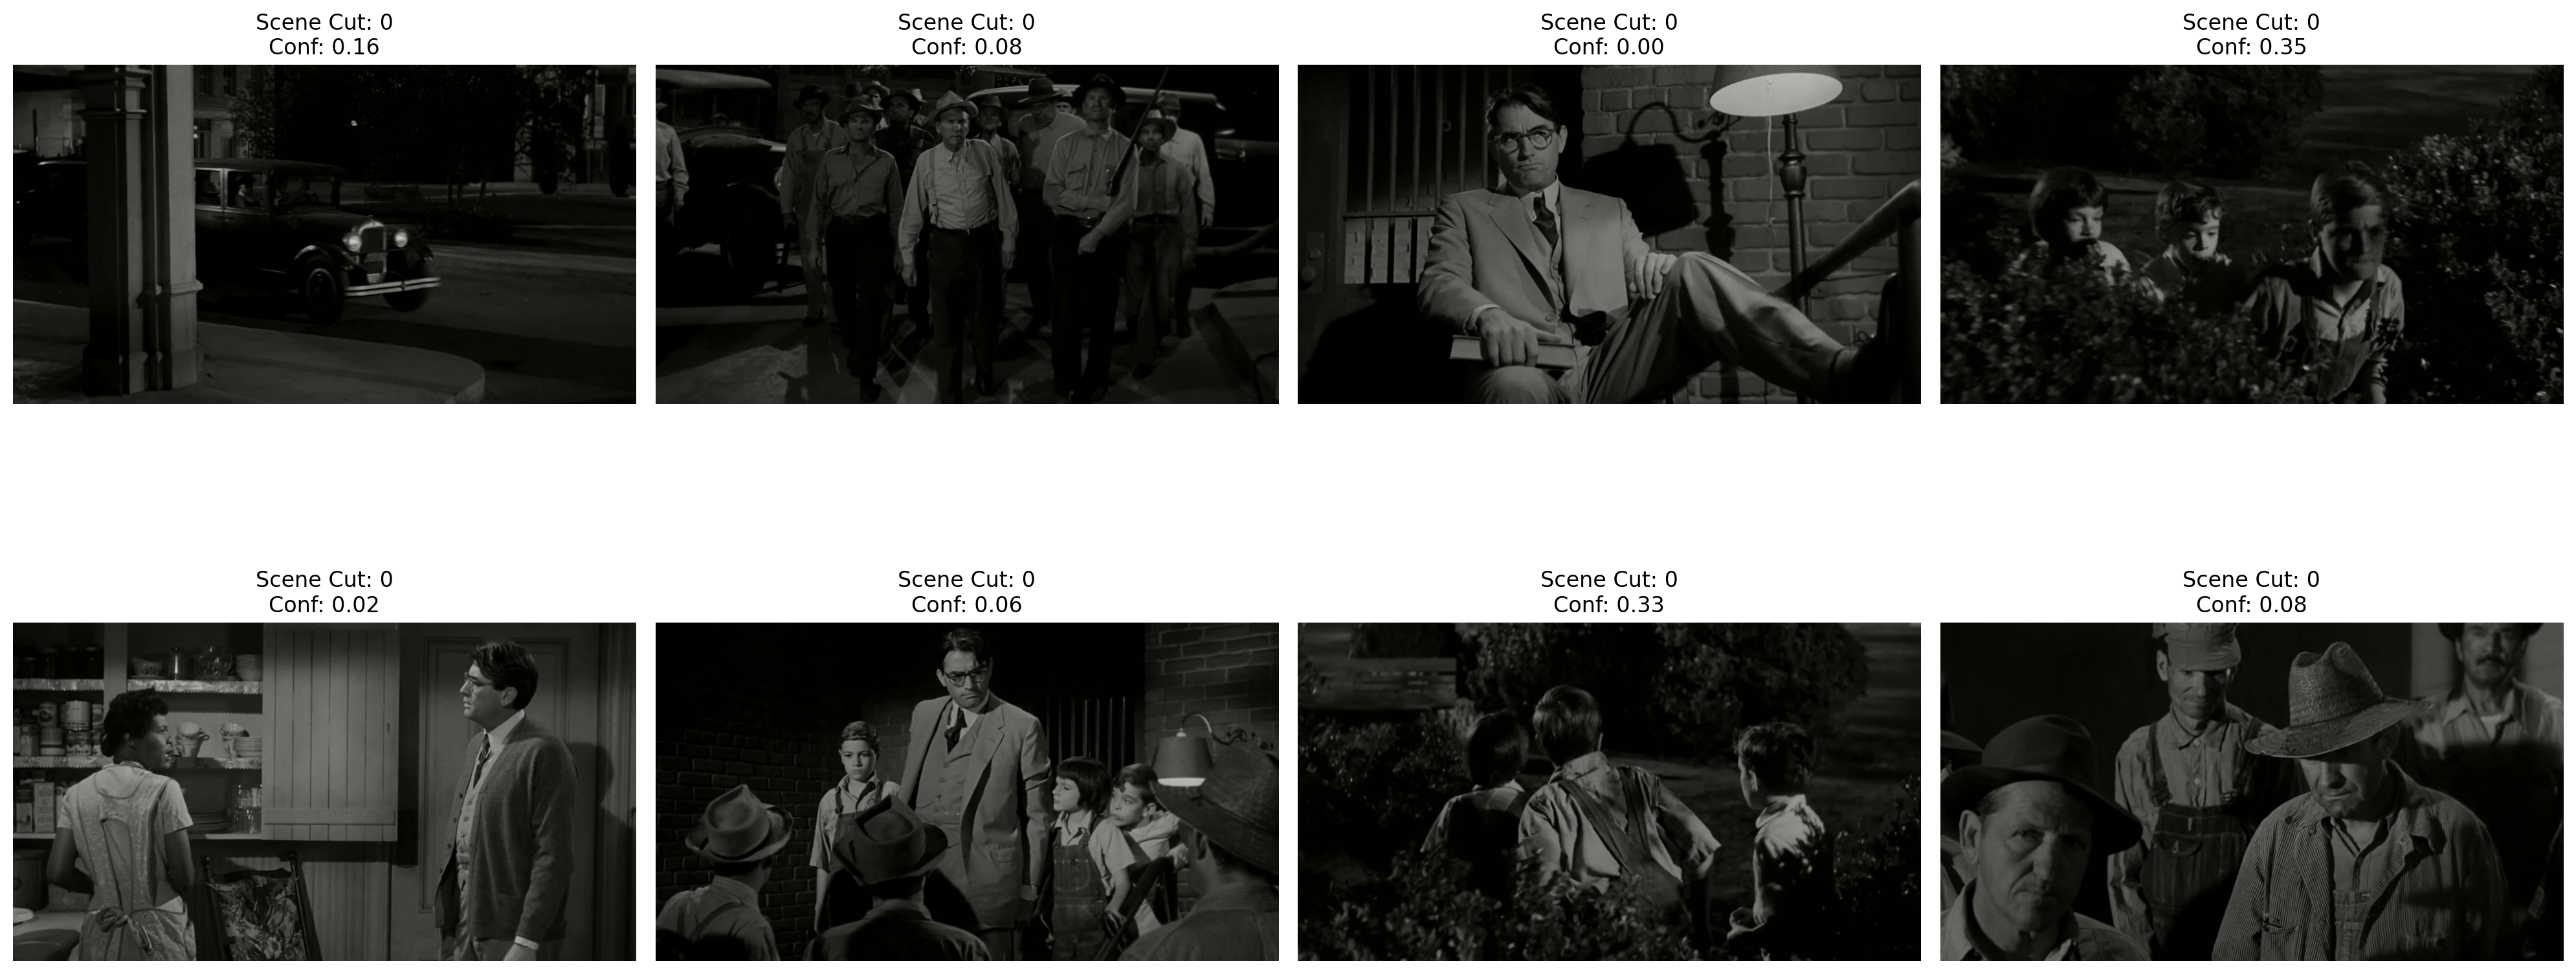


Scene Cut Distribution in Training Set:

Total images: 80
Scene cuts: 0 (0.0%)
Non-scene cuts: 80 (100.0%)
Average scene confidence: 0.106
Average frame difference: 3.289


In [13]:
inspect_data_pipeline()

In [15]:
training_data = enumerate(trainloader)

In [16]:
# Get the first batch
batch_idx, (images, labels_dict) = next(training_data)

# Print information about the batch
print("Batch Information:")
print(f"Batch Index: {batch_idx}")
print(f"Images Type: {type(images)}")
print(f"Images Shape: {images.shape}")
print("\nLabels Information:")
for key, value in labels_dict.items():
    print(f"{key} Shape: {value.shape}")
    print(f"{key} Type: {type(value)}")
    # Print a few example values
    print(f"First few {key} values: {value[:5]}\n")

# If you want to access specific labels
scene_cut_labels = labels_dict['is_scene_cut']
scene_confidence = labels_dict['scene_confidence']
frame_differences = labels_dict['frame_difference']

print("\nSpecific Label Examples:")
print(f"First 5 scene cut labels: {scene_cut_labels[:5]}")
print(f"First 5 confidence scores: {scene_confidence[:5]}")
print(f"First 5 frame differences: {frame_differences[:5]}")

Batch Information:
Batch Index: 0
Images Type: <class 'torch.Tensor'>
Images Shape: torch.Size([32, 3, 696, 1280])

Labels Information:
has_faces Shape: torch.Size([32])
has_faces Type: <class 'torch.Tensor'>
First few has_faces values: tensor([0., 0., 0., 0., 0.])

num_faces Shape: torch.Size([32])
num_faces Type: <class 'torch.Tensor'>
First few num_faces values: tensor([4, 1, 3, 2, 1])

face_confidence Shape: torch.Size([32])
face_confidence Type: <class 'torch.Tensor'>
First few face_confidence values: tensor([0.9989, 0.9928, 0.9988, 0.9990, 0.9872])

is_scene_cut Shape: torch.Size([32])
is_scene_cut Type: <class 'torch.Tensor'>
First few is_scene_cut values: tensor([0., 0., 0., 0., 0.])

scene_confidence Shape: torch.Size([32])
scene_confidence Type: <class 'torch.Tensor'>
First few scene_confidence values: tensor([0.0633, 0.0243, 0.0877, 0.4350, 0.0033])

frame_difference Shape: torch.Size([32])
frame_difference Type: <class 'torch.Tensor'>
First few frame_difference values: tens

Now, let’s turn our trainloader object into an iterator with iter so we may access our images and labels from this generator. We can see the shape as (64 x 3 x 696 x 1280). This means:

* 64: Represents 64 images (batch)
* 3 : Even though the movie is in black and white, there are 3 channels in our data.
* 696 x 1280: the shape of these images so we can visualize it.

Batch Information:
Batch Index: 0
Images Type: <class 'torch.Tensor'>
Images Shape: torch.Size([32, 3, 696, 1280])


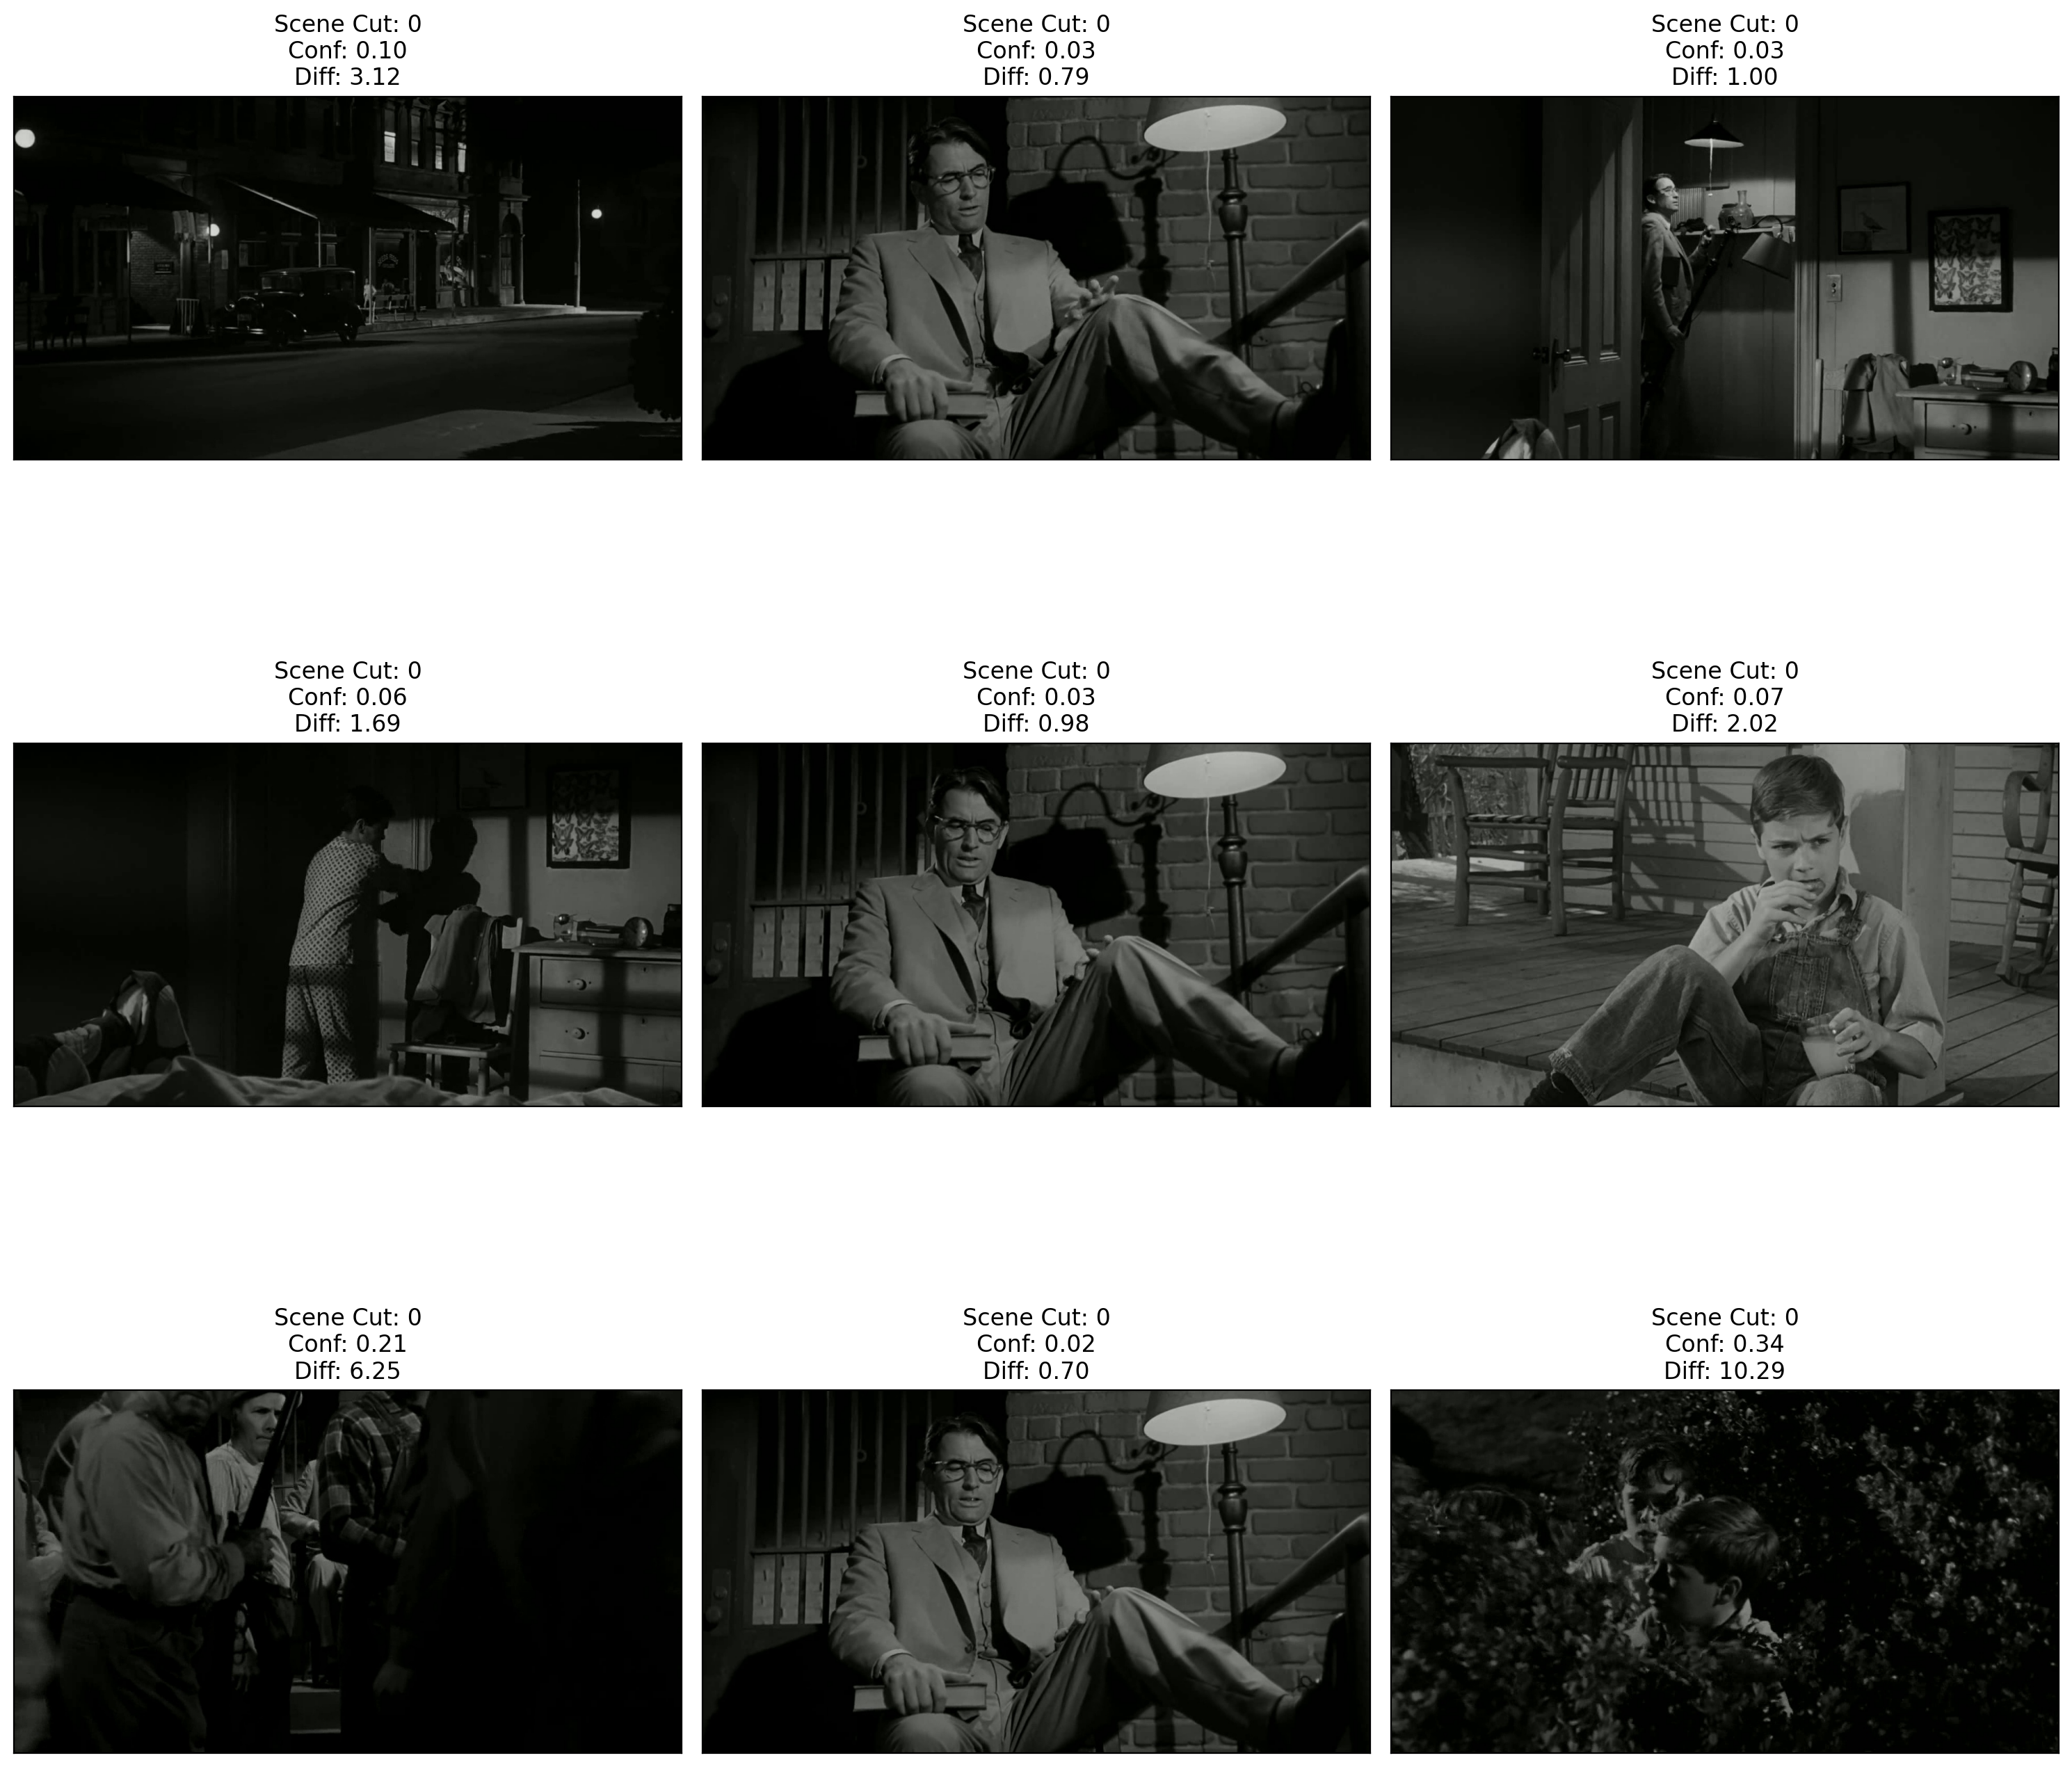


Detailed information for displayed images:

Image 1:
has_faces: 0.000
num_faces: 0.000
face_confidence: 0.000
is_scene_cut: 0.000
scene_confidence: 0.104
frame_difference: 3.117

Image 2:
has_faces: 0.000
num_faces: 1.000
face_confidence: 0.999
is_scene_cut: 0.000
scene_confidence: 0.026
frame_difference: 0.791

Image 3:
has_faces: 0.000
num_faces: 1.000
face_confidence: 0.998
is_scene_cut: 0.000
scene_confidence: 0.033
frame_difference: 0.997

Image 4:
has_faces: 0.000
num_faces: 0.000
face_confidence: 0.000
is_scene_cut: 0.000
scene_confidence: 0.056
frame_difference: 1.686

Image 5:
has_faces: 0.000
num_faces: 1.000
face_confidence: 1.000
is_scene_cut: 0.000
scene_confidence: 0.033
frame_difference: 0.981

Image 6:
has_faces: 0.000
num_faces: 1.000
face_confidence: 0.995
is_scene_cut: 0.000
scene_confidence: 0.067
frame_difference: 2.017

Image 7:
has_faces: 0.000
num_faces: 1.000
face_confidence: 0.999
is_scene_cut: 0.000
scene_confidence: 0.208
frame_difference: 6.250

Image 8:
h

In [17]:
# Get batch information
batch_idx, (images, labels_dict) = next(enumerate(trainloader))
print("Batch Information:")
print(f"Batch Index: {batch_idx}")
print(f"Images Type: {type(images)}")
print(f"Images Shape: {images.shape}")

# Create a figure to display 9 images
fig = plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)

    # Convert image tensor to displayable format
    # Permute from (3, 696, 1280) to (696, 1280, 3)
    img = images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in valid range

    plt.imshow(img)

    # Create a multi-line title with relevant labels
    title = f"Scene Cut: {labels_dict['is_scene_cut'][i].item():.0f}\n"
    title += f"Conf: {labels_dict['scene_confidence'][i].item():.2f}\n"
    title += f"Diff: {labels_dict['frame_difference'][i].item():.2f}"

    plt.title(title)
    plt.yticks([])
    plt.xticks([])

plt.tight_layout()
plt.show()

# Optional: Print additional statistics for these 9 images
print("\nDetailed information for displayed images:")
for i in range(9):
    print(f"\nImage {i+1}:")
    for key, value in labels_dict.items():
        print(f"{key}: {value[i].item():.3f}")

Now let’s build our network using this object-oriented class method within nn.module. We will use 2 fully convolutional layers, Relu activation function and MaxPooling. This will also be coupled along with 2 linear layers with a dropout probability of 0.2 per cent.

Fix Misspelling

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class SceneCutNetwork(nn.Module):
    def __init__(self):
        super(SceneCutNetwork, self).__init__()

        self.convolutional_neural_network_layers = nn.Sequential(
            # First conv layer
            # Input: 3x696x1280
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            # Output: 16x174x320

            # Second conv layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            # Output: 32x44x80

            # Third conv layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            # Output: 64x22x40

            # Fourth conv layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            # Output: 128x10x20
        )

        # Calculate the size of flattened features
        self._to_linear = 128 * 10 * 20  # = 25600

        # Linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(25600, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(128, 2)
        )

    def forward(self, x):
        # Pass through CNN layers
        x = self.convolutional_neural_network_layers(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Pass through linear layers
        x = self.linear_layers(x)

        # Split output into scene cut probability and frame difference
        scene_cut_prob = torch.sigmoid(x[:, 0])  # First output through sigmoid for probability
        frame_diff = x[:, 1]  # Second output raw for frame difference

        return scene_cut_prob, frame_diff

    def test_output_shape(self, input_size=(1, 3, 696, 1280)):
        device = next(self.parameters()).device
        x = torch.randn(input_size).to(device)
        print("\nShape test:")
        print(f"Input shape: {x.shape}")

        x = self.convolutional_neural_network_layers(x)
        print(f"After CNN shape: {x.shape}")

        x = x.view(x.size(0), -1)
        print(f"After flatten shape: {x.shape}")

        scene_cut_prob, frame_diff = self.forward(torch.randn(input_size).to(device))
        print(f"Final output shapes - Scene Cut: {scene_cut_prob.shape}, Frame Diff: {frame_diff.shape}")

        # Print parameter count
        total_params = sum(p.numel() for p in self.parameters())
        print(f"\nTotal parameters: {total_params:,}")


In [19]:
# Create and test the network
model = SceneCutNetwork()
model.test_output_shape()


Shape test:
Input shape: torch.Size([1, 3, 696, 1280])
After CNN shape: torch.Size([1, 128, 10, 20])
After flatten shape: torch.Size([1, 25600])
Final output shapes - Scene Cut: torch.Size([1]), Frame Diff: torch.Size([1])

Total parameters: 13,271,554


In [20]:
model.to(device)

SceneCutNetwork(
  (convolutional_neural_network_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momen

In [21]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## 4. Training and Testing the Model

In [22]:
# Print model architecture
print("\nModel Architecture:")
print(model)

# Print parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Print device for each parameter
print("\nParameter Devices:")
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")


Model Architecture:
SceneCutNetwork(
  (convolutional_neural_network_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SceneCutNetwork(nn.Module):
    def __init__(self):
        super(SceneCutNetwork, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Calculate the size of flattened features
        with torch.no_grad():
            x = torch.randn(1, 3, 696, 1280)
            x = self._forward_conv(x)
            self._to_linear = x.numel() // x.shape[0]
            print(f"Flattened size: {self._to_linear}")

        # Linear layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)

    def _forward_conv(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 2)
        return x

    def forward(self, x):
        # Convolutional layers
        x = self._forward_conv(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)

        # Split outputs
        scene_cut_prob = torch.sigmoid(x[:, 0])
        frame_diff = x[:, 1]

        return scene_cut_prob, frame_diff

# Test the model
print("Testing model initialization and forward pass...")
model = SceneCutNetwork()
print("Model created successfully")

# Test forward pass
test_input = torch.randn(4, 3, 696, 1280)
print("\nTesting forward pass with batch size 4...")
with torch.no_grad():
    scene_cut_prob, frame_diff = model(test_input)
    print(f"Forward pass successful")
    print(f"Scene cut probability shape: {scene_cut_prob.shape}")
    print(f"Frame difference shape: {frame_diff.shape}")

# Only after successful CPU test, move to CUDA
if torch.cuda.is_available():
    print("\nMoving model to CUDA...")
    try:
        model = model.cuda()
        print("Model successfully moved to CUDA")

        # Test CUDA forward pass
        test_input = torch.randn(4, 3, 696, 1280).cuda()
        with torch.no_grad():
            scene_cut_prob, frame_diff = model(test_input)
            print("CUDA forward pass successful")
    except Exception as e:
        print(f"CUDA error: {str(e)}")
        print("Keeping model on CPU")
        model = model.cpu()

# Print model summary
print("\nModel architecture:")
print(model)

# Print parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Testing model initialization and forward pass...
Flattened size: 1920
Model created successfully

Testing forward pass with batch size 4...
Forward pass successful
Scene cut probability shape: torch.Size([4])
Frame difference shape: torch.Size([4])

Moving model to CUDA...
Model successfully moved to CUDA
CUDA forward pass successful

Model architecture:
SceneCutNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [24]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Initialize model and keep it on CPU
model = SceneCutNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scene_cut_criterion = nn.BCELoss()
frame_diff_criterion = nn.MSELoss()
writer = SummaryWriter()

print('Starting Training on CPU')
epochs = 10

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Print example batch information
example_images, example_labels = next(iter(trainloader))
print(f"\nBatch information:")
print(f"Image batch shape: {example_images.shape}")
print(f"Scene cut labels shape: {example_labels['is_scene_cut'].shape}")
print(f"Frame diff labels shape: {example_labels['frame_difference'].shape}")

t0 = time.time()

for epoch in range(epochs):
    t1 = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for idx, (images, labels_dict) in enumerate(trainloader):
        # Ensure all tensors are on CPU and correct type
        images = images.float()
        scene_cut_labels = labels_dict['is_scene_cut'].float()
        frame_diff_labels = labels_dict['frame_difference'].float()

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        scene_cut_pred, frame_diff_pred = model(images)

        # Debug info for first batch of first epoch
        if epoch == 0 and idx == 0:
            print("\nFirst batch details:")
            print(f"Scene cut predictions range: {scene_cut_pred.min().item():.3f} to {scene_cut_pred.max().item():.3f}")
            print(f"Scene cut labels: {scene_cut_labels[:5]}")
            print(f"Frame diff predictions range: {frame_diff_pred.min().item():.3f} to {frame_diff_pred.max().item():.3f}")
            print(f"Frame diff labels: {frame_diff_labels[:5]}")

        # Calculate losses
        scene_cut_loss = scene_cut_criterion(scene_cut_pred, scene_cut_labels)
        frame_diff_loss = frame_diff_criterion(frame_diff_pred, frame_diff_labels)
        loss = scene_cut_loss + 0.5 * frame_diff_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss += loss.item()
        predicted = (scene_cut_pred >= 0.5).float()
        train_total += scene_cut_labels.size(0)
        train_correct += (predicted == scene_cut_labels).sum().item()

        # Print progress every 100 batches
        if idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {idx}, Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels_dict in testloader:
            images = images.float()
            scene_cut_labels = labels_dict['is_scene_cut'].float()
            frame_diff_labels = labels_dict['frame_difference'].float()

            scene_cut_pred, frame_diff_pred = model(images)

            scene_cut_loss = scene_cut_criterion(scene_cut_pred, scene_cut_labels)
            frame_diff_loss = frame_diff_criterion(frame_diff_pred, frame_diff_labels)
            loss = scene_cut_loss + 0.5 * frame_diff_loss

            test_loss += loss.item()
            predicted = (scene_cut_pred >= 0.5).float()
            test_total += scene_cut_labels.size(0)
            test_correct += (predicted == scene_cut_labels).sum().item()

    # Calculate epoch metrics
    train_loss_avg = train_loss/len(trainloader)
    test_loss_avg = test_loss/len(testloader)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    train_losses.append(train_loss_avg)
    test_losses.append(test_loss_avg)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch: {epoch+1}/{epochs}  ",
          f"Training loss: {train_loss_avg:.4f}  ",
          f"Testing loss: {test_loss_avg:.4f}  ",
          f"Train accuracy: {train_acc:.2f}%  ",
          f"Test accuracy: {test_acc:.2f}%  ",
          f"Epoch time: {time.time() - t1:.2f}s")

print("Training Complete")
print(f"Total Elapsed Time: {time.time() - t0:.2f}s")

# Save the model
torch.save(model.state_dict(), 'scene_cut_model_cpu.pth')

Flattened size: 1920
Starting Training on CPU

Batch information:
Image batch shape: torch.Size([32, 3, 696, 1280])
Scene cut labels shape: torch.Size([32])
Frame diff labels shape: torch.Size([32])

First batch details:
Scene cut predictions range: 0.387 to 0.541
Scene cut labels: tensor([0., 0., 0., 0., 0.])
Frame diff predictions range: -0.315 to 0.266
Frame diff labels: tensor([ 1.7830, 10.2924,  1.1586,  0.2716,  0.5469])
Epoch 1, Batch 0, Loss: 6.4252
Epoch: 1/10   Training loss: 21.9430   Testing loss: 13.7897   Train accuracy: 92.50%   Test accuracy: 100.00%   Epoch time: 36.40s
Epoch 2, Batch 0, Loss: 9.2191
Epoch: 2/10   Training loss: 13.7568   Testing loss: 13.6943   Train accuracy: 100.00%   Test accuracy: 100.00%   Epoch time: 18.90s
Epoch 3, Batch 0, Loss: 4.7908
Epoch: 3/10   Training loss: 12.0620   Testing loss: 12.2904   Train accuracy: 100.00%   Test accuracy: 100.00%   Epoch time: 17.93s
Epoch 4, Batch 0, Loss: 7.5927
Epoch: 4/10   Training loss: 18.0892   Testing 

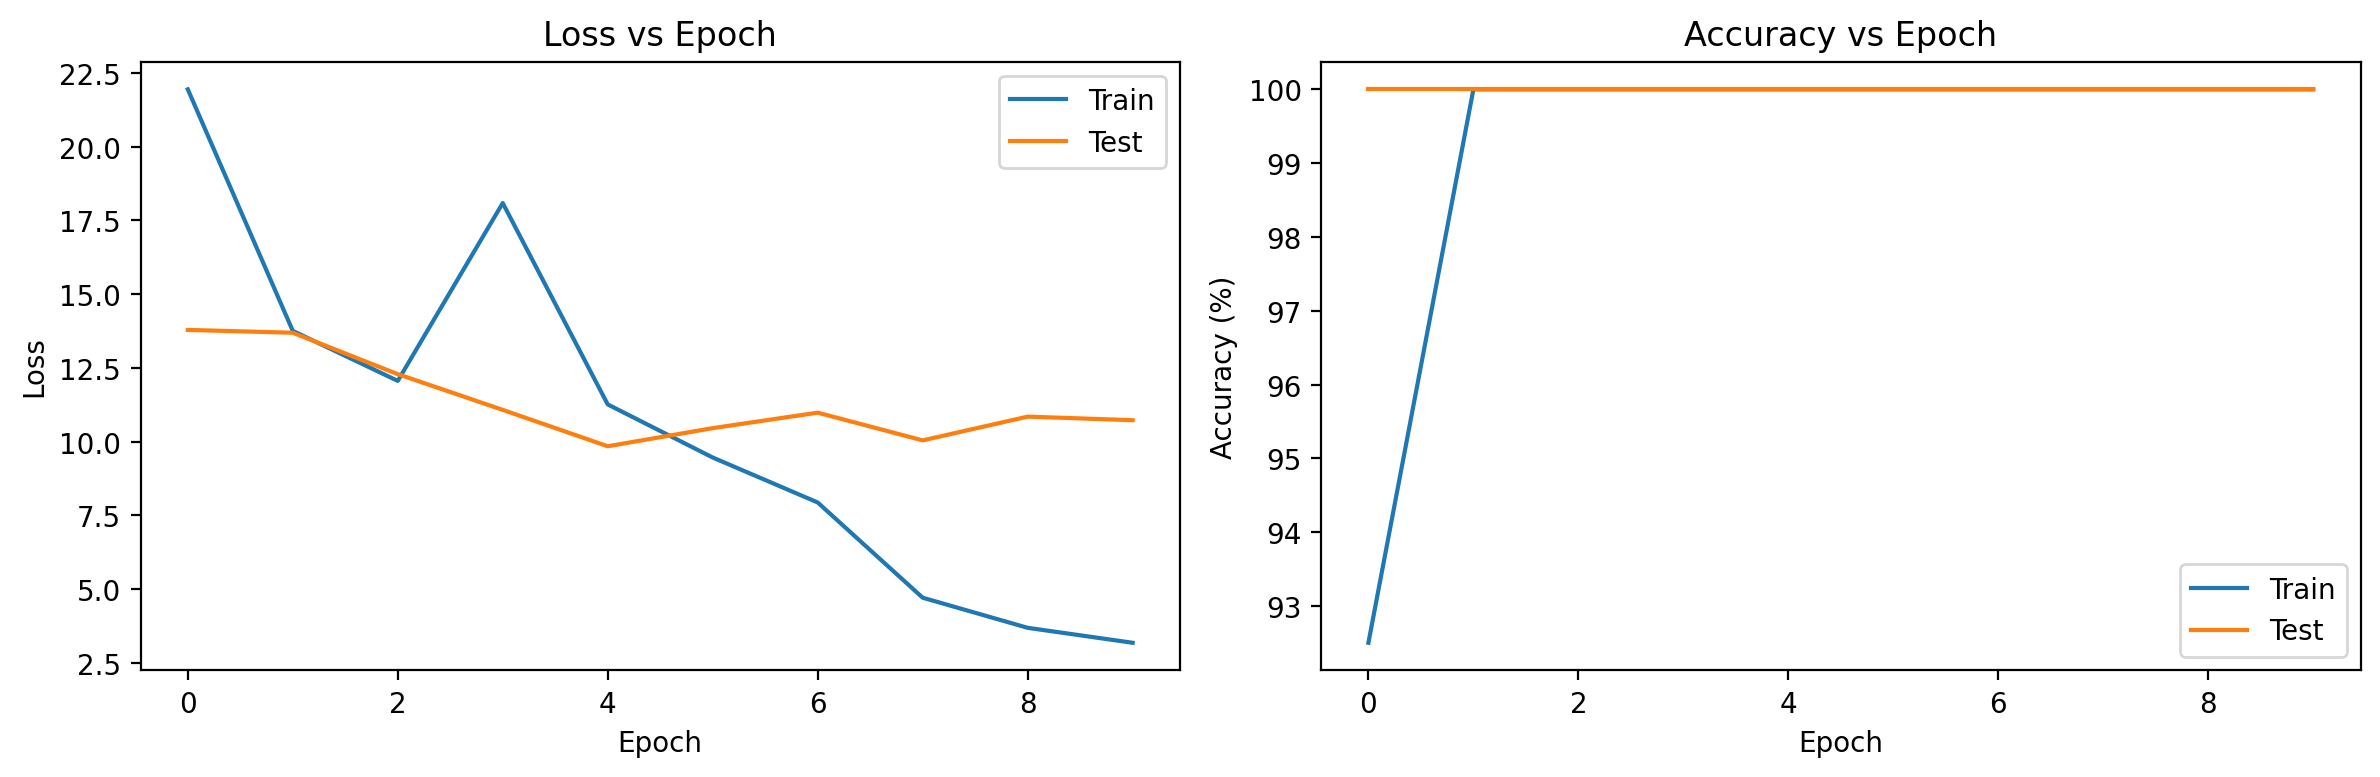

In [25]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

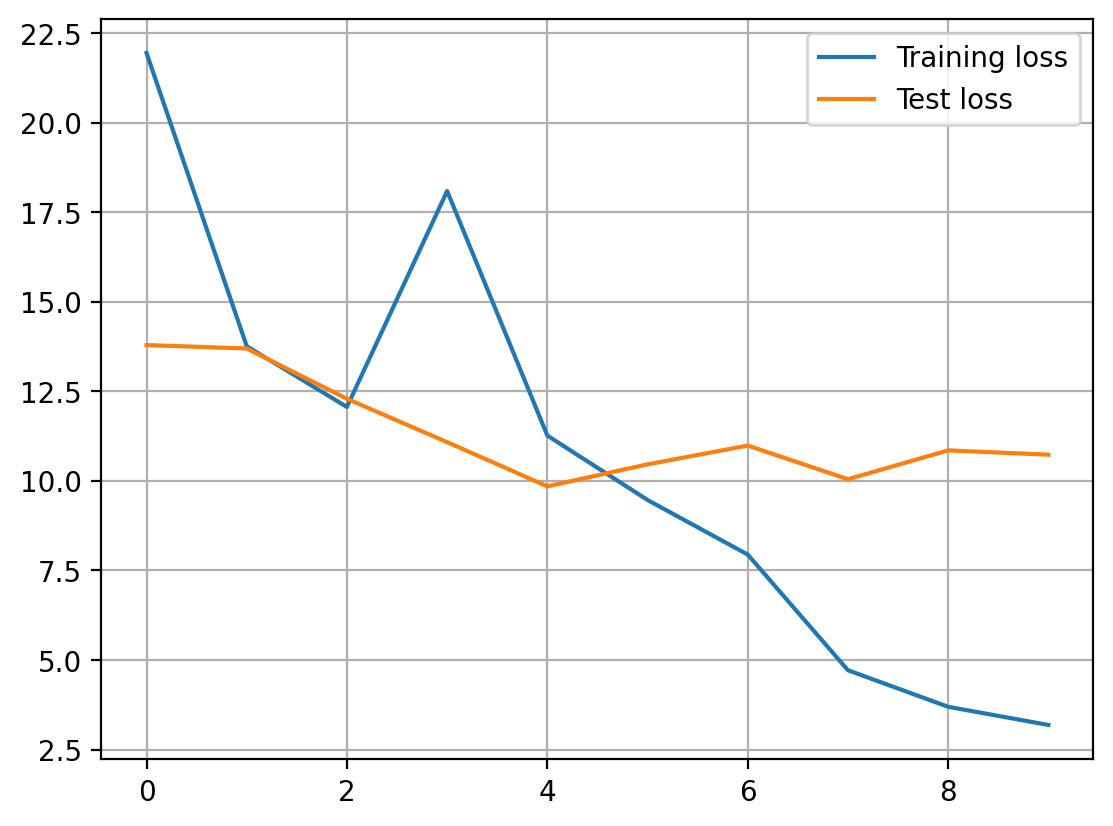

In [26]:
# plot the training and test losses
plt.plot(train_losses, label='Training loss')
plt.plot(np.array([test_loss for test_loss in test_losses]), label='Test loss')
plt.legend()
plt.grid()
plt.show()

Let’s check our training and validation accuracy. It is as simple as the code for plotting the loss.

## 5. Evaluating the Network

In [29]:
def test_single_image(dataset, index, model, device):
    """
    Test a single image from the dataset using the trained model

    Args:
        dataset: Your ImageLabelDataset instance
        index: Index of the image to test
        model: Your trained model
        device: torch device (cuda or cpu)
    """
    # First, ensure the model is on the correct device
    model = model.to(device)

    # Get the image and its labels
    img, labels = dataset[index]

    # Add batch dimension and move to device
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)

    print(f"Input image shape: {img.shape}")
    print(f"Image device: {img.device}")
    print(f"Model device: {next(model.parameters()).device}")

    # Turn off gradients for prediction
    with torch.no_grad():
        outputs = model(img)

    return outputs, labels

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Select an index to test (e.g., 11)
test_idx = 11

# Make sure the index is within the dataset size
if test_idx < len(dataset):
    try:
        outputs, true_labels = test_single_image(dataset, test_idx, model, device)

        print("\nModel outputs:", outputs)
        print("\nTrue labels:")
        for key, value in true_labels.items():
            print(f"{key}: {value}")

    except Exception as e:
        print(f"Error during prediction: {str(e)}")
else:
    print(f"Index {test_idx} is out of range. Dataset size is {len(dataset)}")

# Optional: If you want to visualize the image
def visualize_test_image(dataset, index):
    import matplotlib.pyplot as plt

    img, _ = dataset[index]

    # Convert tensor to numpy and transpose to correct format for plotting
    img_np = img.numpy().transpose(1, 2, 0)

    # If the image appears too dark or bright, you might want to normalize it
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

Using device: cuda
Input image shape: torch.Size([1, 3, 696, 1280])
Image device: cuda:0
Model device: cuda:0

Model outputs: (tensor([0.0771], device='cuda:0'), tensor([1.4466], device='cuda:0'))

True labels:
has_faces: 0.0
num_faces: 1
face_confidence: 0.998847246170044
is_scene_cut: 0.0
scene_confidence: 0.01926705427467823
frame_difference: 0.5780116319656372


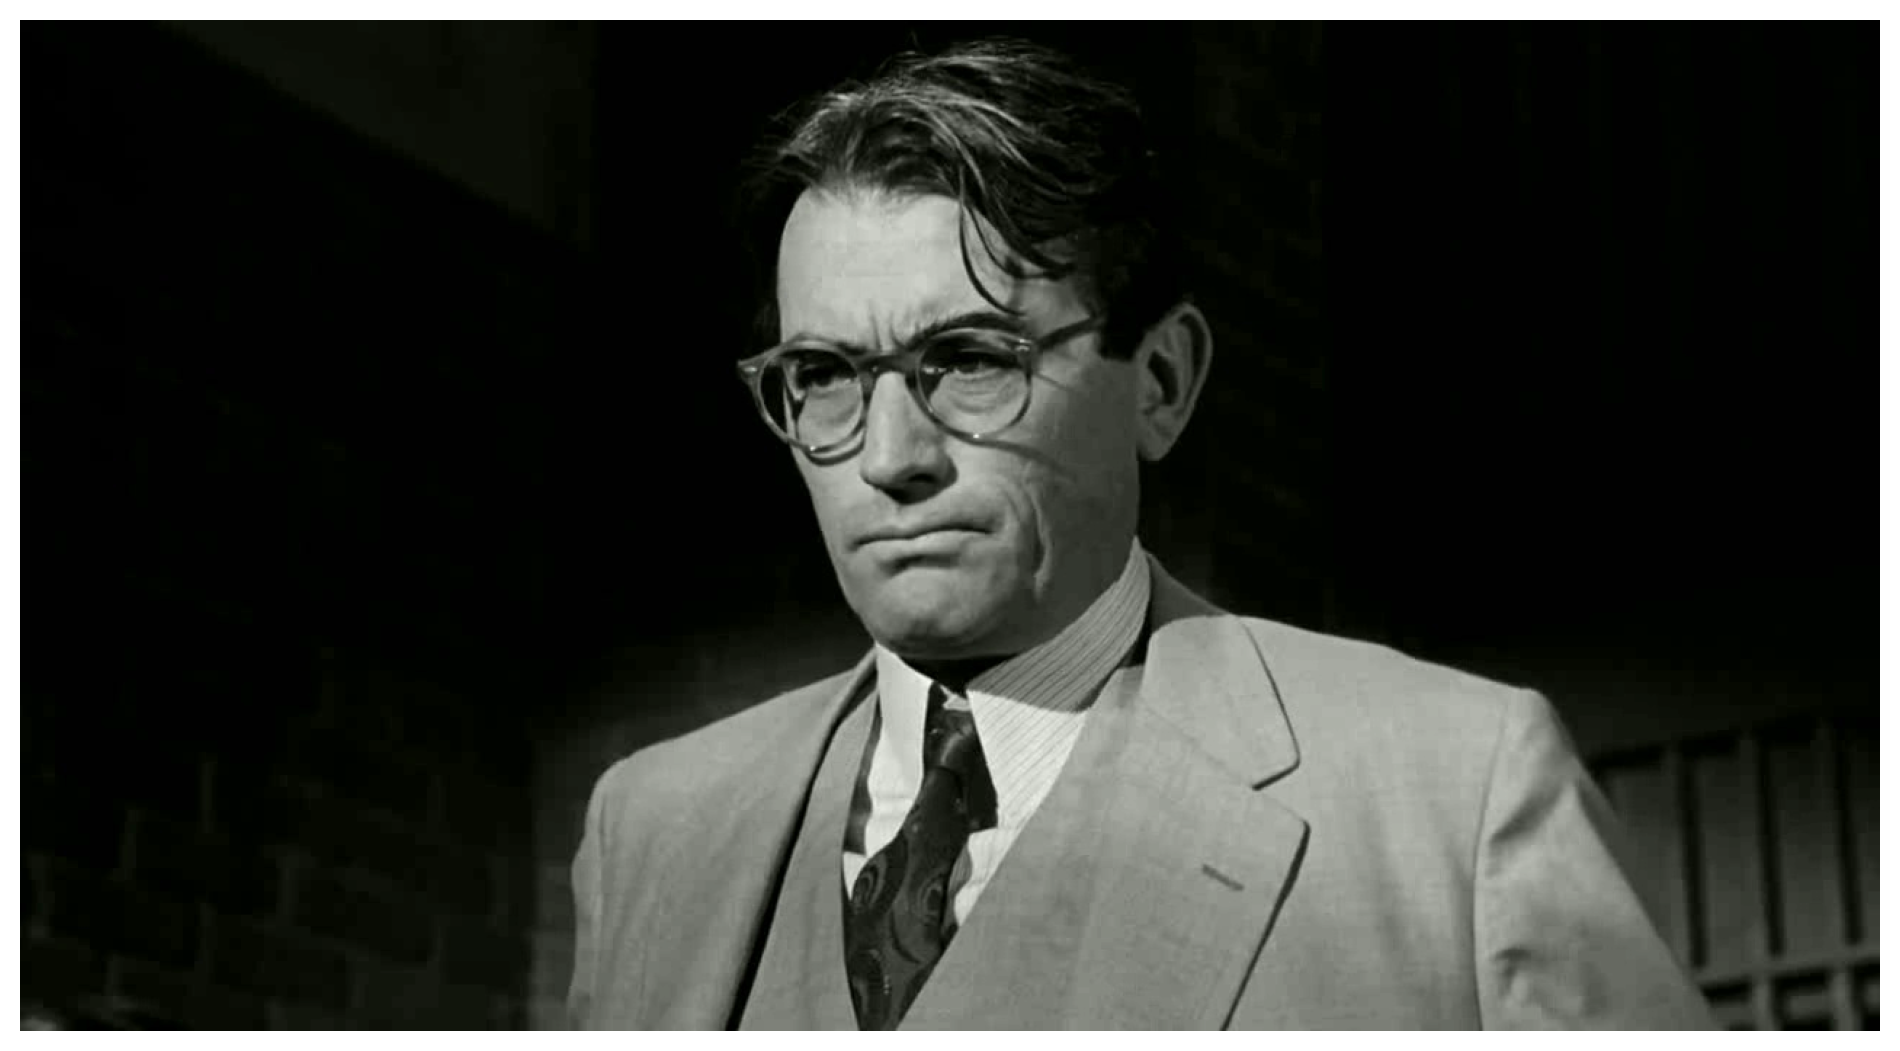

In [30]:
visualize_test_image(dataset, test_idx)

In [35]:
def visualize_predictions(img, outputs, true_labels):
    """
    Visualize the image and model predictions

    Args:
        img: Input image tensor
        outputs: Model outputs dictionary
        true_labels: True labels dictionary
    """
    import matplotlib.pyplot as plt
    import torch.nn.functional as F
    import numpy as np

    # Convert model outputs to probabilities where appropriate
    probabilities = {}

    # Apply sigmoid for binary classifications and store probabilities
    if 'has_faces' in outputs:
        probabilities['has_faces'] = torch.sigmoid(outputs['has_faces']).cpu().numpy().squeeze()
    if 'is_scene_cut' in outputs:
        probabilities['is_scene_cut'] = torch.sigmoid(outputs['is_scene_cut']).cpu().numpy().squeeze()

    # Store confidence scores directly
    if 'face_confidence' in outputs:
        probabilities['face_confidence'] = outputs['face_confidence'].cpu().numpy().squeeze()
    if 'scene_confidence' in outputs:
        probabilities['scene_confidence'] = outputs['scene_confidence'].cpu().numpy().squeeze()
    if 'frame_difference' in outputs:
        probabilities['frame_difference'] = outputs['frame_difference'].cpu().numpy().squeeze()

    # Create visualization
    fig = plt.figure(figsize=(15, 6))

    # Create grid layout: 1 row, 2 columns
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot image
    ax1 = plt.subplot(gs[0])
    img_np = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize for visualization
    ax1.imshow(img_np)
    ax1.axis('off')
    ax1.set_title('Input Image')

    # Plot predictions
    ax2 = plt.subplot(gs[1])

    # Prepare data for plotting
    labels = []
    values = []
    colors = []

    # Binary classifications (show both prediction and ground truth)
    for key in ['has_faces', 'is_scene_cut']:
        if key in probabilities:
            labels.append(f'{key} (pred)')
            values.append(probabilities[key])
            colors.append('blue')

            # Add ground truth
            labels.append(f'{key} (true)')
            values.append(float(true_labels[key]))
            colors.append('green')

    # Confidence scores and other metrics
    for key in ['face_confidence', 'scene_confidence', 'frame_difference']:
        if key in probabilities:
            labels.append(key)
            values.append(probabilities[key])
            colors.append('red')

    # Create horizontal bar chart
    y_pos = np.arange(len(labels))
    ax2.barh(y_pos, values, color=colors)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_title('Predictions & Ground Truth')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

    # Print numerical values
    print("\nNumerical Predictions:")
    for key, value in probabilities.items():
        print(f"{key}: {value:.4f}")

    print("\nGround Truth:")
    for key, value in true_labels.items():
        print(f"{key}: {value}")
